In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as mdt
import MDAnalysis as mda
import aimmd
import aimmd.distributed as aimmdd

Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `aimmd.distributed.slurm.reinitialize_slurm_settings()` with the appropriate arguments.
Tensorflow/Keras not available


In [3]:
# setup working directory

#scratch_dir = "."
#scratch_dir = "/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/"
scratch_dir = "/home/think/scratch/aimmd_distributed/"

workdir = os.path.join(scratch_dir, "PathSampling_mda_test")

if not os.path.isdir(workdir):
    os.mkdir(workdir)

In [4]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [5]:
# have a look at the default logging level (the level used for the root logger)
print(LOGCONFIG["loggers"][""])
# have a look at the logger for aimmd
print(LOGCONFIG["loggers"]["aimmd"])
# and have a look at the log-level for the filehandler
print(LOGCONFIG["handlers"]["stdf"])
# the last two should both be `INFO`

{'level': 'WARN', 'handlers': ['stdf', 'warnout']}
{'level': 'INFO'}
{'class': 'logging.FileHandler', 'level': 'INFO', 'mode': 'w', 'filename': 'simulation.log', 'formatter': 'standardFormatter'}


In [6]:
# OPTIONAL: more logging
#LOGCONFIG["handlers"]["stdf"]["level"] = "DEBUG"
#LOGCONFIG["loggers"]["aimmd"]["level"] = "DEBUG"

In [7]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
LOGCONFIG["handlers"]["stdf"]["filename"] = os.path.join(workdir, "simulation_pathsampling.log")
LOGCONFIG["handlers"]["initf"]["filename"] = os.path.join(workdir, "initlog_pathsampling.log")
logging.config.dictConfig(LOGCONFIG)

# now the actual setup

In [8]:
n_chains = 4  # results in 2*n_chains gmx engines

In [9]:
storage = aimmd.Storage(os.path.join(workdir, "storage.h5"))

In [10]:
# Define the engine(s) for the PathMovers
# (they will all be the same)
gro = "gmx_infiles/conf.gro"
top = "gmx_infiles/topol_amber99sbildn.top"
ndx = "gmx_infiles/index.ndx"
mdp = aimmdd.MDP("gmx_infiles/md.mdp")

gmx_engine_kwargs = {"mdp": mdp,
                     "gro_file": gro,
                     "top_file": top,
                     "ndx_file": ndx,
                     "mdrun_extra_args": "-nt 2",
                     # use this for gmx sans (thread) MPI
                     #"mdrun_extra_args": "-ntomp 2",
                     }
gmx_engine_cls = aimmdd.GmxEngine

In [11]:
# state functions
from state_funcs_mda import alpha_R, C7_eq

wrapped_alphaR = aimmdd.PyTrajectoryFunctionWrapper(alpha_R)

wrapped_C7_eq = aimmdd.PyTrajectoryFunctionWrapper(C7_eq)

In [12]:
# descriptor_transform for the model

# internal coordinates
from state_funcs_mda import descriptor_func_ic

wrapped_transform = aimmdd.PyTrajectoryFunctionWrapper(descriptor_func_ic, call_kwargs={"molecule_selection": "protein"})

In [13]:
# load initial transitions
tp_lb = aimmdd.Trajectory(structure_file="gmx_infiles/ala_300K_amber99sb-ildn.tpr", trajectory_file="gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr")
tp_short = aimmdd.Trajectory(structure_file="gmx_infiles/ala_300K_amber99sb-ildn.tpr", trajectory_file="gmx_infiles/TP_short_low_barrier_300K_amber99sbildn.trr")
tp_short2 = aimmdd.Trajectory(structure_file="gmx_infiles/ala_300K_amber99sb-ildn.tpr", trajectory_file="gmx_infiles/TP_short2_low_barrier_300K_amber99sbildn.trr")

In [14]:
print([len(tp) for tp in [tp_lb, tp_short, tp_short2]])

[102, 18, 28]


In [15]:
# get the descriptors for one of them to infer the number of inputs for our model
descriptors_for_tp = await wrapped_transform(tp_lb)
descriptors_for_tp_short = await wrapped_transform(tp_short)
descriptors_for_tp_short2 = await wrapped_transform(tp_short2)

In [16]:
await wrapped_alphaR(tp_short)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [17]:
await wrapped_C7_eq(tp_short)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True])

In [18]:
# imports for model
import torch.nn.functional as F
import torch

In [19]:
# model definition
n_lay_pyramid = 5
n_unit_top = 10
dropout_base = 0.3
n_unit_base = cv_ndim = descriptors_for_tp.shape[1]
fact = (n_unit_top / n_unit_base)**(1./(n_lay_pyramid))

modules = []

for i in range(1, n_lay_pyramid + 1):
    #print(f"ResUnit {i} is {max(n_unit_top, int(n_unit_base * fact**(i-1)))} units wide.")
    #modules += [aimmd.pytorch.networks.ResNet(n_units=max(n_unit_top, int(n_unit_base * fact**(i-1))),
    #                                          n_blocks=1)
    #            ]

    modules += [aimmd.pytorch.networks.FFNet(n_in=max(n_unit_top, int(n_unit_base * fact**(i-1))),
                                             n_hidden=[max(n_unit_top, int(n_unit_base * fact**i))],  # 1 hidden layer network
                                             activation=torch.nn.Identity(),
                                             dropout={"0": dropout_base * fact**i}
                                             )
                ]
    print(f"ResUnit {i} is {max(n_unit_top, int(n_unit_base * fact**(i)))} units wide.")
    print(f"Dropout before it is {dropout_base * fact**i}.")
    modules += [aimmd.pytorch.networks.ResNet(n_units=max(n_unit_top, int(n_unit_base * fact**i)),
                                              n_blocks=1)
                ]

torch_model = aimmd.pytorch.networks.ModuleStack(n_out=1,  # using a single output we will predict only p_B and use a binomial loss
                                                           # we could have also used n_out=n_states to use a multinomial loss and predict all states,
                                                           # but this is probably only worthwhile if n_states > 2 as it would increase the number of free parameters in the NN
                                                 modules=modules,  # modules is a list of initialized torch.nn.Modules from arcd.pytorch.networks
                                                 )

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    torch_model = torch_model.to('cuda')

# choose and initialize an optimizer to train the model
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-3)

ResUnit 1 is 66 units wide.
Dropout before it is 0.18674307214231128.
ResUnit 2 is 41 units wide.
Dropout before it is 0.1162432499771616.
ResUnit 3 is 25 units wide.
Dropout before it is 0.07235873872180604.
ResUnit 4 is 16 units wide.
Dropout before it is 0.045041643884176266.
ResUnit 5 is 10 units wide.
Dropout before it is 0.02803738317757008.


In [20]:
# we take an ExpectedEfficiencyPytorchRCModel,
# this RCmodel scales the learning rate by the expected efficiency factor (1 - n_TP_true / n_TP_expected)**2
model = aimmd.pytorch.EEScalePytorchRCModelAsync(nnet=torch_model,
                                                 optimizer=optimizer,
                                                 states=[wrapped_C7_eq, wrapped_alphaR],
                                                 ee_params={'lr_0': 1e-3,  
                                                            #'lr_min': 5e-5,  # lr_min = lr_0 / 20 is a good choice empirically
                                                            'lr_min': 5e-5,
                                                            #'epochs_per_train': 3, # try 5, [10 and 15] next
                                                            'epochs_per_train': 5,
                                                            #'interval': 5,
                                                            'interval': 10,
                                                            #'window': 75,
                                                            'window': 100,
                                                           },
                                                 descriptor_transform=wrapped_transform,
                                                 cache_file=storage,
                                                 )

In [21]:
# we could use a list with initialized movers
#movers = [[aimmdd.TwoWayShootingPathMover(states=[wrapped_C7_eq, wrapped_alphaR],
#                                          engine_cls=gmx_engine_cls,
#                                          engine_kwargs=gmx_engine_kwargs,
#                                          engine_config=mdp,
#                                          walltime_per_part=0.01,
#                                          T=mdp["ref-t"][0],
#                                         )
#           ] for i in range(n_chains)
#         ]

# it is easier though to use the `Brain.chains_from_moverlist()` function
# this function will create n-chain identical PathSamplingChains where the movers for each chain are
# specified by movers_cls (a list of mover classes) and movers_kwargs (a dict with keyword arguments used for initialization of the movers)
movers_cls = [aimmdd.pathmovers.TwoWayShootingPathMover]
movers_kwargs = [{'states': [wrapped_alphaR, wrapped_C7_eq],
                  'engine_cls': gmx_engine_cls,
                  'engine_kwargs': gmx_engine_kwargs,
                  # NOTE: choose this as short as possible!
                  #       since ala is super-small and commits fast we should make sure
                  #       that most trials reach a state in the first part
                  #       this in turn makes sure that we do not call gromasc multiple times per trial (saving setup time)
                  #       but still ensures that the resulting trajectories are not too long and large
                  #       it also reduces the time needed per step (we need at least walltime_per_part hours per step)
                  'walltime_per_part': 0.000015625,  # 0.055125 s per part
                  #'walltime_per_part': 0.00003125,  # 0.1125 s per part
                  #'walltime_per_part': 0.0000625,  # 0.225 s per part
                  #'walltime_per_part': 0.000125,  # 0.45 s per part
                  #'walltime_per_part': 0.00025,  # 0.9 s per part
                  #'walltime_per_part': 0.0005,  # 1.8 s per part
                  #'walltime_per_part': 0.001,  # 3.6 s per part
                  #'walltime_per_part': 0.002,  # 7.2 s per part
                  #'walltime_per_part': 0.003,  # 10.8 s per part
                  #'walltime_per_part': 0.004,  # 14.4 s per part
                  'T': mdp["ref-t"][0],
                  "sp_selector": aimmdd.pathmovers.RCModelSPSelector(),  # can be used to customize SP-selection params 
                  }
                 ]

In [22]:
trainset = aimmd.TrainSet(n_states=2)

In [23]:
tasks = [aimmdd.pathsampling.TrainingTask(model=model, trainset=trainset),
         aimmdd.pathsampling.SaveTask(storage=storage, model=model, trainset=trainset),
         aimmdd.pathsampling.DensityCollectionTask(model=model,
                                                   first_collection=100,
                                                   recreate_interval=500,
                                                   interval=10
                                                   ),
         ]

In [24]:
# this would be the full __init__ call to the brain
# it gives you full flexibility of setting up every PathSamplingChain individually
#brain = aimmdd.Brain(model=model, workdir=workdir, storage=storage, movers=movers, mover_weights=[[1.], [1.], [1.]], tasks=tasks)

# this is the 'easy' way
brain = aimmdd.Brain.chains_from_moverlist(model=model, workdir=workdir, storage=storage, n_chain=n_chains,
                                           movers_cls=movers_cls, movers_kwargs=movers_kwargs, tasks=tasks)
                                           # Note that we left mover_weights=None at its default, this results
                                           # in uniform weights for all movers

In [25]:
# NOTE: old cumbersome setup

#initial_step = aimmdd.logic.MCstep(mover=None, stepnum=0, directory="gmx_infiles", path=tp_short, accepted=True)
#initial_step2 = aimmdd.logic.MCstep(mover=None, stepnum=0, directory="gmx_infiles", path=tp_long, accepted=True)

# take two different initial TPs
#for i, c in enumerate(brain.chains):
#    if i == 2:
#        c.current_step = initial_step2
#        c.chainstore.append(initial_step2)  # save the initial step as first step of every chain
#    else:
#        c.current_step = initial_step
#        c.chainstore.append(initial_step)  # save the initial step as first step of every chain


# NEW: use the new seed_initial_paths() method!
# have a look at before
for i, c in enumerate(brain.chains):
    print(f"Chain {i}: ", c.current_step)
    print()
# seed them
brain.seed_initial_paths(trajectories=[tp_lb, tp_short, tp_short2], weights=[1., 1., 1.])
# have a look again
for i, c in enumerate(brain.chains):
    print(f"Chain {i}: ")
    print(f"MCstep {c.current_step}, with path {c.current_step.path}.")
    print()

Chain 0:  None

Chain 1:  None

Chain 2:  None

Chain 3:  None

Chain 0: 
MCstep Accepted MCStep(mover=None, stepnum=0, states_reached=None, p_acc=1, predicted_committors_sp=None,
directory=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles), with path Trajectory(trajectory_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/TP_short2_low_barrier_300K_amber99sbildn.trr, structure_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/ala_300K_amber99sb-ildn.tpr).

Chain 1: 
MCstep Accepted MCStep(mover=None, stepnum=0, states_reached=None, p_acc=1, predicted_committors_sp=None,
directory=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles), with path Trajectory(trajectory_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr, structure_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/ala_300K_amber99sb-ild

In [26]:
import time

In [27]:
n_steps = 500
start = time.time()

await brain.run_for_n_steps(n_steps)
#await brain.run_for_n_steps(2000)
#await brain.run_for_n_accepts(25)

end = time.time()
print(f"Running for {n_steps} cummulative MCSteps took {end-start} s (= {(end-start)/60} min).")

Running for 500 cummulative MCSteps took 579.3919835090637 s (= 9.656533058484396 min).


In [28]:
print(model.log_train_decision[-1])

[True, 6.61305181266888e-05, 5, None]


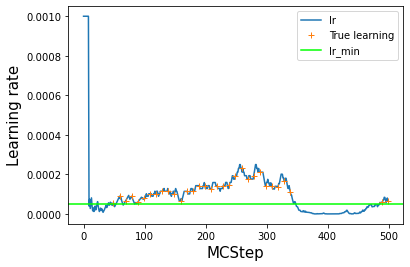

In [29]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

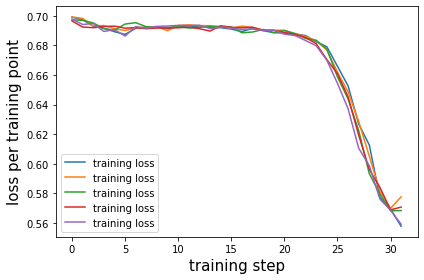

In [30]:
# the model losses at each step where it trained
# this will be epochs_per_training loss values per training
plt.plot(model.log_train_loss, label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('training step', size=15)
plt.tight_layout()

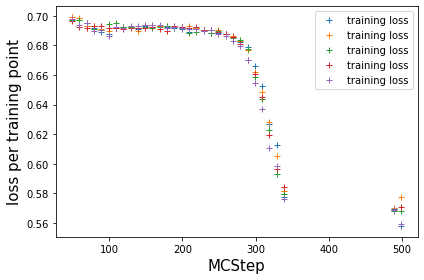

In [31]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

In [32]:
# TODO: find a way, currently it is not possibly to get the accepts in the same order as the trainset?!
# TODO: probably we will have to write a DataCollectionTask to achieve that ?!
# get accepts from storage:
# NOTE: this is just roughly the right order
accepts = []
for accs in zip(*(c.accepts for c in brain.chains)):
    accepts += list(accs)

In [33]:
brain.accepts[-20:]  # this is the right order!

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

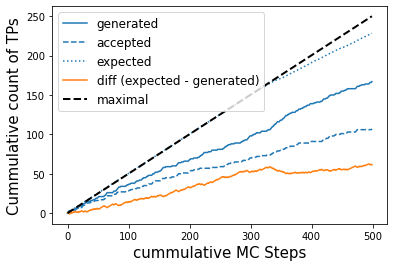

In [34]:
# plot efficiency, expected efficiency and accepts
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)

p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(brain.accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (expected - generated)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=12);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('cummulative MC Steps', size=15);

In [35]:
hipr = aimmd.analysis.HIPRanalysis(model, trainset)

In [36]:
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(25)

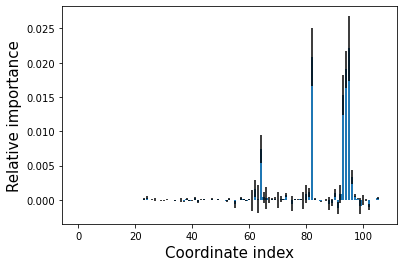

In [37]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [38]:
from state_funcs_mda import generate_atomgroups_for_ic

u = mda.Universe("gmx_infiles/ala_300K_amber99sb-ildn.tpr", "gmx_infiles/conf.gro",
                 refresh_offsets=True, tpr_resid_from_one=True)
molecule = u.select_atoms('protein')
pairs, triples, quadruples = generate_atomgroups_for_ic(molecule)

In [39]:
# what are the most important contributors?
max_idxs = np.argsort(loss_diffs)[::-1]
sf_parms = {}

#pairs, triples, quadruples = aimmd.coords.internal.generate_indices(traj.topology, source_idx=1)

ic_parms = {"pairs": pairs, "triples": triples, "quadruples": quadruples}

print('reference loss:', hipr_plus_losses[-1])
for idx in max_idxs[:10]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_plus_losses[idx])
    if idx < len(pairs[0]):
        print(f"bond between: {pairs[0][idx]} and {pairs[1][idx]}")
        continue
    idx -= len(pairs[0])
    if idx < len(triples[0]):
        print(f"angle between {triples[0][idx]}, {triples[1][idx]} and {triples[2][idx]}")
        continue
    idx -= len(triples[0])
    if idx % 2 == 0:
        st = "sinus"
    else:
        st = "cosinus"
    st += f" of dihedral between {quadruples[0][idx // 2]}, {quadruples[1][idx // 2]}, {quadruples[2][idx // 2]} and {quadruples[3][idx // 2]}."
    print(st)
    #print(aimmd.coords.get_involved(idx, sf_parms=sf_parms, ic_parms=ic_parms, solvent_atoms=[['O', 'H']], solvent_resname=['HOH']))

reference loss: 0.5476565704345703

loss for idx 95:  0.5697546405029297
sinus of dihedral between <Atom 11: CB of type CT of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 9: CA of type CT of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 15: C of type C of resname ALA, resid 2 and segid seg_0_Protein_chain_A> and <Atom 17: N of type N of resname NME, resid 3 and segid seg_0_Protein_chain_A>.

loss for idx 82:  0.5685296240234375
cosinus of dihedral between <Atom 7: N of type N of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 9: CA of type CT of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 15: C of type C of resname ALA, resid 2 and segid seg_0_Protein_chain_A> and <Atom 17: N of type N of resname NME, resid 3 and segid seg_0_Protein_chain_A>.

loss for idx 94:  0.5666773709106446
cosinus of dihedral between <Atom 10: HA of type H1 of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 9: CA of type CT of resname ALA,

In [40]:
# save the last model
storage.rcmodels["model_to_continue_with"] = model
storage.save_trainset(trainset)
# the rest should be saved automatically
# maybe we should save the model + trainset at the end of the simulation autmatically too?!

In [41]:
storage.close()

In [68]:
%%bash
which gmx

/usr/local/gromacs-2020.4/bin/gmx


In [69]:
(await wrapped_transform(storage.central_memory[0][8].path)).shape

(20, 107)

In [70]:
for s in brain.storage.central_memory[0][:5]:
    print(s.mover)
    print(s.mover is brain.chains[0].movers[0])
    print(s.mover == brain.chains[0].movers[0])

None
False
False
False
False
False
False
False
False
False
False


In [61]:
storage.close()